In [1]:
import matplotlib
import seaborn
import pandas
import networkx
import tqdm
import gzip
import igraph

from collections import Counter, OrderedDict

%matplotlib inline

In [2]:
ecosystems = ['pypi', 'npm', 'cran']

COLORS = {ecos: seaborn.color_palette()[i] for i, ecos in enumerate(ecosystems)}
FIG_SIZE = (6, 3)
FIG_SIZE_WIDE = (10, 3)
SHOW_TITLE = False

def savefig(fig, name):
    # Uncomment next line to disable export
    # return
    return fig.savefig('../figures/{}.pdf'.format(name), bbox_inches='tight')

In [3]:
graphs = OrderedDict()
df_all_packages = OrderedDict()
df_packages = OrderedDict()
df_all_deps = OrderedDict()
df_deps = OrderedDict()

for ecos in ecosystems:
    with gzip.GzipFile('../../{}/data/packages.csv.gz'.format(ecos)) as f:
        packages = pandas.read_csv(f, index_col=[0,1], parse_dates=['time'])
    with gzip.GzipFile('../../{}/data/deps.csv.gz'.format(ecos)) as f:
        deps = pandas.read_csv(f)

    print(ecos)
    print(len(packages.groupby(level=0)), 
          'packages,',
          len(packages), 'versions and',
          len(deps), 'dependencies')
    print('from', min(packages.time), 'to', max(packages.time))
        
    df_all_packages[ecos] = packages
    df_all_deps[ecos] = deps
    
    # Take latest version of each package
    packages = packages.dropna().sort_values('time').groupby(level=0, sort=False).tail(1)
    deps = packages.merge(deps, how='inner', left_index=True, right_on=['package', 'version']).dropna()

    print(len(deps), 'dependencies kept')
    print('versions from', packages.time.min(), 'to', packages.time.max())
    print()
    
    # Filter out dependencies that are not registered packages
    deps = packages.reset_index().merge(deps, how='inner', left_on='package', right_on='dependency', suffixes=('_2', ''))
    
    df_packages[ecos] = packages
    df_deps[ecos] = deps
    
    # Construct graph
    graph = igraph.Graph(directed=True)
    graph.add_vertices(packages.index.get_level_values('package'))
    edges = [(row.package, row.dependency) for row in deps[['package', 'dependency']].itertuples()]
    graph.add_edges(edges)
    
    graphs[ecos] = graph
    

pypi
82134 packages, 508373 versions and 154833 dependencies
from 2005-03-21 15:59:25 to 2016-06-25 00:11:15
19172 dependencies kept
versions from 2005-04-18 14:47:04 to 2016-06-25 00:11:15

npm
317159 packages, 1927750 versions and 7692501 dependencies
from 1970-01-01 00:00:00 to 2016-06-28 14:35:28.717000
729059 dependencies kept
versions from 2010-12-19 09:45:59.546000 to 2016-06-28 14:35:28.717000

cran
9568 packages, 57530 versions and 203265 dependencies
from 1997-10-08 19:56:17 to 2016-04-26 20:52:26
9337 dependencies kept
versions from 1997-10-08 19:56:17 to 2016-04-26 20:52:26



df = df_packages['npm']
df = df.reset_index()[['package', 'version']]
url = 'https://registry.npmjs.org/{package}/-/{package}-{version}.tgz'
with open('npm-download.txt', 'w') as f:
    for t in df.itertuples():
        f.write(url.format(package=t.package, version=t.version) + '\n')

## Overview

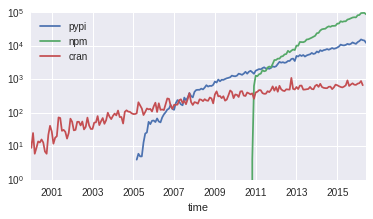

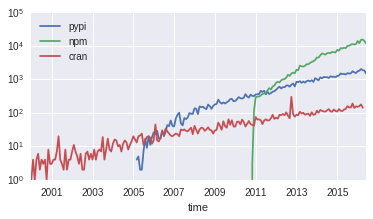

In [25]:
fig_v, ax_v = matplotlib.pyplot.subplots()
fig_p, ax_p = matplotlib.pyplot.subplots()

fig_v.set_size_inches(FIG_SIZE)
fig_p.set_size_inches(FIG_SIZE)

if SHOW_TITLE:
    ax_v.set_title('New versions by month (log scale)')
    ax_p.set_title('New packages by month (log scale)')

for ecos, all_packages in df_all_packages.items():
    df1 = (all_packages
            .set_index('time')
            .assign(n=1)
            .resample('1M')
            .sum()
            .fillna(0)
            .rename(columns={'n': ecos})
          )
    df1.plot(ax=ax_v, logy=True)
    
    df2 = (all_packages
            .groupby(level=0)
            .min()
            .set_index('time')
            .assign(n=1)
            .resample('1M')
            .sum()
            .fillna(0)
            .rename(columns={'n': ecos})
          )
    df2.plot(ax=ax_p, logy=True)

ax_v.set_xlim(pandas.to_datetime('2000-01-01'))
ax_p.set_xlim(pandas.to_datetime('2000-01-01'))

savefig(fig_v, 'evol_versions')
savefig(fig_p, 'evol_packages')

## Packages and Dependencies

In [40]:
data = {ecos: {} for ecos in graphs.keys()}
for ecos, graph in graphs.items():
    data[ecos]['packages'] = graph.vcount()
    data[ecos]['dependencies'] = graph.ecount()
    data[ecos]['avg_deps_by_pkg'] = graph.ecount() / graph.vcount()
    data[ecos]['pkg_with_deps'] = len([True for d in graph.outdegree() if d > 0])
    data[ecos]['pkg_with_rev_deps'] = len([True for d in graph.indegree() if d > 0])
    data[ecos]['pkg_non_isolated'] = len([True for d in graph.degree() if d > 0])
    data[ecos]['pkg_isolated'] = len([True for d in graph.degree() if d == 0])
df = pandas.DataFrame.from_dict(data, orient='index')
df

,avg_deps_by_pkg,pkg_non_isolated,pkg_with_deps,pkg_with_rev_deps,dependencies,pkg_isolated,packages
cran,0.394022,2449,1921,872,3770,7119,9568
npm,2.287331,207364,185228,66129,725450,109796,317160
pypi,0.185856,5860,4288,2063,13758,68165,74025


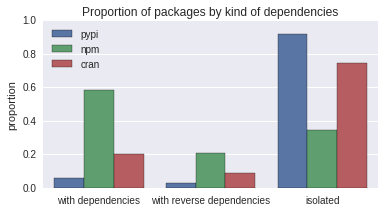

In [41]:
df['with_deps'] = df['pkg_with_deps'] / df['packages']
df['with_rev_deps'] = df['pkg_with_rev_deps'] / df['packages']
df['isolated'] = df['pkg_isolated'] / df['packages']

data = pandas.melt(
    df[['with_deps', 'with_rev_deps', 'isolated']]
      .reset_index()
      .rename(columns={'index': 'ecosystem', 'with_deps': 'with dependencies', 'with_rev_deps': 'with reverse dependencies'}),
    id_vars='ecosystem', 
    value_vars=['with dependencies', 'with reverse dependencies', 'isolated'], 
    var_name='kind', 
    value_name='value')

ax = seaborn.barplot(hue='ecosystem', y='value', x='kind', data=data, hue_order=graphs.keys())
ax.set_xlabel('')
ax.set_ylabel('proportion')
ax.legend(title=None, loc='upper left')

if SHOW_TITLE:
    ax.set_title('Proportion of packages by kind of dependencies')
ax.figure.set_size_inches(FIG_SIZE)

savefig(ax.figure, 'pkg_overview')

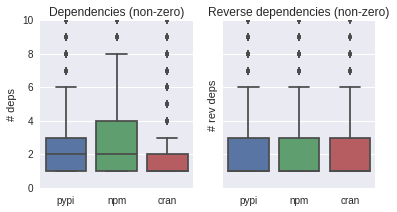

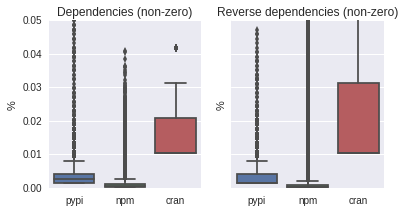

In [7]:
data_in = []
data_in_p = []
data_out = []
data_out_p = []

for ecos, graph in graphs.items():
    n = graph.vcount()
    for d in graph.outdegree():
        if d > 0:
            data_out.append((ecos, d))
            data_out_p.append((ecos, 100 * d / n))
            
    for d in graph.indegree():
        if d > 0:
            data_in.append((ecos, d))
            data_in_p.append((ecos, 100 * d / n))

fig, axes = matplotlib.pyplot.subplots(ncols=2, sharey=True, sharex=True)            

ax = seaborn.boxplot(0, 1, data=pandas.DataFrame.from_records(data_out), ax=axes[0])
ax.set_ylim(0, 10)
ax.set_xlabel('')
ax.set_ylabel('# deps')
ax.set_title('Dependencies (non-zero)')

ax = seaborn.boxplot(0, 1, data=pandas.DataFrame.from_records(data_in), ax=axes[1])
ax.set_ylim(0, 10)
ax.set_xlabel('')
ax.set_ylabel('# rev deps')
ax.set_title('Reverse dependencies (non-zero)')

fig.set_size_inches(FIG_SIZE)
savefig(fig, 'distr_deps')



fig, axes = matplotlib.pyplot.subplots(ncols=2, sharey=True, sharex=True)            

ax = seaborn.boxplot(0, 1, data=pandas.DataFrame.from_records(data_out_p), ax=axes[0])
ax.set_ylim(0, 0.05)
ax.set_xlabel('')
ax.set_ylabel('%')
ax.set_title('Dependencies (non-zero)')

ax = seaborn.boxplot(0, 1, data=pandas.DataFrame.from_records(data_in_p), ax=axes[1])
ax.set_ylim(0, 0.05)
ax.set_xlabel('')
ax.set_ylabel('%')
ax.set_title('Reverse dependencies (non-zero)')

fig.set_size_inches(FIG_SIZE)
savefig(fig, 'distr_deps_relative')

In [8]:
print('Most required packages')
for ecos, graph in graphs.items():
    print(ecos, ':', end=' ')
    for vertex, degree in sorted(zip(graph.vs, graph.indegree()), key=lambda x: x[1], reverse=True)[:10]:
        print('{} ({})'.format(vertex['name'], degree), end=', ')
    print()

print()

print('Most dependent packages')
for ecos, graph in graphs.items():
    print(ecos, ':', end=' ')
    for vertex, degree in sorted(zip(graph.vs, graph.outdegree()), key=lambda x: x[1], reverse=True)[:10]:
        print('{} ({})'.format(vertex['name'], degree), end=', ')
    print()

Most required packages
pypi : requests (795), numpy (673), six (637), pytest (319), coverage (290), scipy (282), matplotlib (226), pbr (219), pytest-cov (194), mock (193), 
npm : lodash (23306), request (14571), async (14089), underscore (11976), commander (9409), express (9365), chalk (8964), debug (8463), bluebird (7261), mkdirp (6326), 
cran : Rcpp (468), ggplot2 (126), httr (84), dplyr (74), rJava (62), Matrix (55), stringr (51), data.table (49), jsonlite (43), plyr (42), 

Most dependent packages
pypi : sentry (98), invenio-records-rest (50), invenio-migrator (49), invenio-openaire (48), invenio-previewer (47), invenio-communities (46), gnocchi (43), invenio-logging (40), cameo (40), invenio-files-rest (39), 
npm : mikolalysenko-hoarders (389), terrible-lodash (309), smasher (130), lodash-modularized (129), compute.io (122), bb-lp-cli (115), smashing-dev-tool (114), brainfock (114), cordova-plugin-require-bluetoothle (112), files-and-folders-server (110), 
cran : radiant (19), AFM

In [34]:
data = []

for ecos, graph in graphs.items():
    nodes = graph.vs
    for node in nodes:
        n_out = -1  # ignore source
        n_in = -1  # Ignore source
        for target in graph.bfsiter(node):
            n_out += 1
        for target in graph.bfsiter(node, mode=igraph.IN):
            n_in += 1
        data.append((ecos, n_out, n_in))

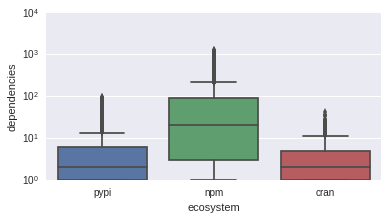

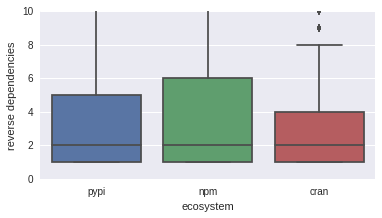

In [37]:
df = pandas.DataFrame.from_records(data, columns=['ecosystem', 'tran_dep', 'rev_tran_dep'])

for label, col in [('dependencies', 'tran_dep'), ('reverse dependencies', 'rev_tran_dep')]:
    fig, ax = matplotlib.pyplot.subplots()
    seaborn.boxplot(x='ecosystem', y=col, data=df.query('{} > 0'.format(col)), ax=ax)
    
    ax.set_ylabel(label)
    ax.set_yscale('log')

    fig.set_size_inches(FIG_SIZE)

    if SHOW_TITLE:
        ax.set_title('Number of transitive {} (non-zero)'.format(label))
    
    if col == 'rev_tran_dep':
        ax.set_yscale('linear')
        ax.set_ylim(0, 10)        
    
    savefig(fig, col)

## Connected components

In [120]:
data = {ecos: {} for ecos in graphs.keys()}
for ecos, graph in graphs.items():
    for component, size in Counter(len(component) for component in graph.components(mode=igraph.WEAK)).items():
        data[ecos][component] = size
df = pandas.DataFrame.from_dict(data)
print('Number of (weakly) connected components by component size')
df.T.fillna(0)

Number of (weakly) connected components by component size


,1,2,3,4,5,6,7,8,9,10,...,27,28,32,35,36,41,106,2126,5434,201593
cran,7119.0,76.0,30.0,8.0,1.0,2.0,2.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
npm,109810.0,1486.0,296.0,119.0,40.0,32.0,9.0,11.0,11.0,1.0,...,1.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
pypi,68166.0,140.0,14.0,6.0,2.0,3.0,2.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


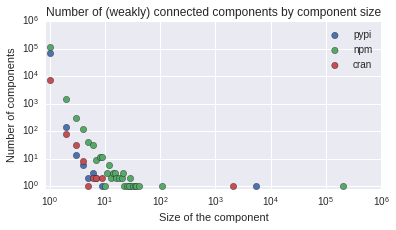

In [121]:
d = df.reset_index().rename(columns={'index': 'component'})
d = pandas.melt(d, id_vars='component', value_vars=['cran', 'npm', 'pypi'], var_name='ecosystem', value_name='size').dropna()

ax = None
for i, ecos in enumerate(graphs.keys()):
    kwargs = {
        'x': 'component', 
        'y': 'size',
        'label': ecos,
        'logx': True,
        'logy': True,
        's': 40,
        'color': COLORS[ecos]
    }
    if ax:
        kwargs['ax'] = ax
        
    ax = d.query('ecosystem == "{}"'.format(ecos)).plot.scatter(**kwargs)
ax.set_xlabel('Size of the component')
ax.set_ylabel('Number of components')
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

if SHOW_TITLE:
    ax.set_title('Number of (weakly) connected components by component size')

ax.figure.set_size_inches(FIG_SIZE)
savefig(ax.figure, 'weakly_components')

g = graphs['npm']
clusters = g.clusters(mode=igraph.WEAK)
for component in clusters:
    if len(component) == 106:
        break
subgraph = g.subgraph(component)
n = 0
for line in subgraph.get_adjacency():
    #    print(''.join((str(x) for x in line)))
    n += line[-1]
list(g['name'] for g in subgraph.vs)

In [13]:
data_aspl = []
for ecos, graph in graphs.items():
    clusters = graph.clusters(mode=igraph.WEAK)
    
    for component in tqdm.tqdm(clusters, desc=ecos):
        subgraph = graph.subgraph(component)
        n = subgraph.vcount()
        
        if 1 < n < 200000:
            n_paths = 0
            sum_paths = 0
            for paths in subgraph.shortest_paths_dijkstra(mode=igraph.ALL):
                n_paths += len(paths)
                sum_paths += sum(paths)
            
            data_aspl.append((ecos, n, sum_paths / n_paths))

# NPM's largest component was ignored during the computation here above
# because it takes a while to compute its aspl. The result was previously 
# computed, and is now hard-coded here:
data_aspl.append(('npm', 201593, 4.1))            

cran: 100%|██████████| 7241/7241 [00:00<00:00, 11664.56it/s]


In [67]:
df = pandas.DataFrame.from_records(data_aspl, columns=['ecosystem', 'component', 'aspl'])
df.sort_values('component', ascending=False).groupby('ecosystem').head(5).sort_values('ecosystem')

,ecosystem,component,aspl
2211,cran,2126,4.769485
2270,cran,9,2.098765
2275,cran,9,1.950617
2239,cran,7,1.795918
2253,cran,7,1.224490
2333,npm,201593,4.100000
779,npm,106,2.580100
914,npm,41,2.057109
1768,npm,36,2.155864
1138,npm,35,2.894694


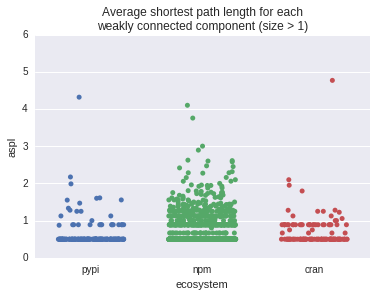

In [70]:
ax = seaborn.stripplot('ecosystem', 'aspl', data=df, jitter=0.3)
ax.set_title('Average shortest path length for each\nweakly connected component (size > 1)')

## Hubs and Authorities

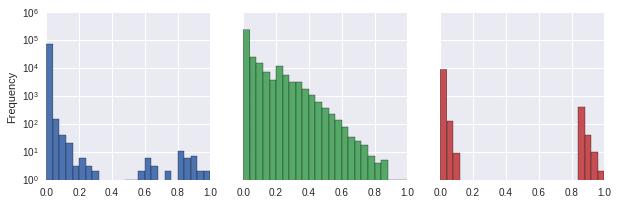

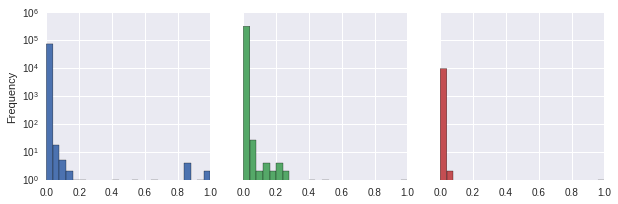

In [16]:
fig_hubs, ax_hubs = matplotlib.pyplot.subplots(ncols=3, sharey=True)
fig_hubs.set_size_inches(FIG_SIZE_WIDE)

fig_auth, ax_authorities = matplotlib.pyplot.subplots(ncols=3, sharey=True)
fig_auth.set_size_inches(FIG_SIZE_WIDE)

for i, (ecos, graph) in enumerate(graphs.items()):
    hubs, authorities = graph.hub_score(), graph.authority_score()
    hubs, authorities = pandas.Series(hubs), pandas.Series(authorities)
    hubs.plot.hist(label=ecos, ax=ax_hubs[i], bins=25, logy=True, color=COLORS[ecos])
    authorities.plot.hist(label=ecos, ax=ax_authorities[i], bins=25, logy=True, color=COLORS[ecos])
    if SHOW_TITLE:
        ax_hubs[i].set_title('Hubs for {}'.format(ecos))
        ax_authorities[i].set_title('Authorities for {}'.format(ecos))
    
savefig(fig_hubs, 'hubs')
savefig(fig_auth, 'auths')

## Pagerank

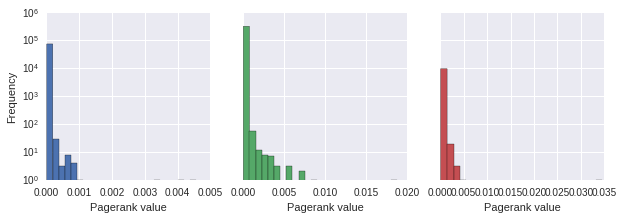

In [17]:
fig, axes = matplotlib.pyplot.subplots(ncols=3, sharey=True)
fig.set_size_inches(FIG_SIZE_WIDE)

for i, (ecos, graph) in enumerate(graphs.items()):
    pagerank = graph.pagerank()
    pandas.Series(pagerank).plot.hist(label=ecos, ax=axes[i], bins=25, logy=True, color=COLORS[ecos])
    if SHOW_TITLE:
        axes[i].set_title(ecos)
    axes[i].set_xlabel('Pagerank value')
    
savefig(fig, 'pagerank')